# Lab 2: Image Sampling and Quantization
## Student ID: 2447218

This notebook demonstrates:
1. Loading and grayscale conversion
2. Sampling techniques with different interpolation methods
3. Quantization at different bit levels
4. Analysis of artifacts and quality degradation


In [1]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib parameters for better visualization
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10


## 1. Load Image and Convert to Grayscale


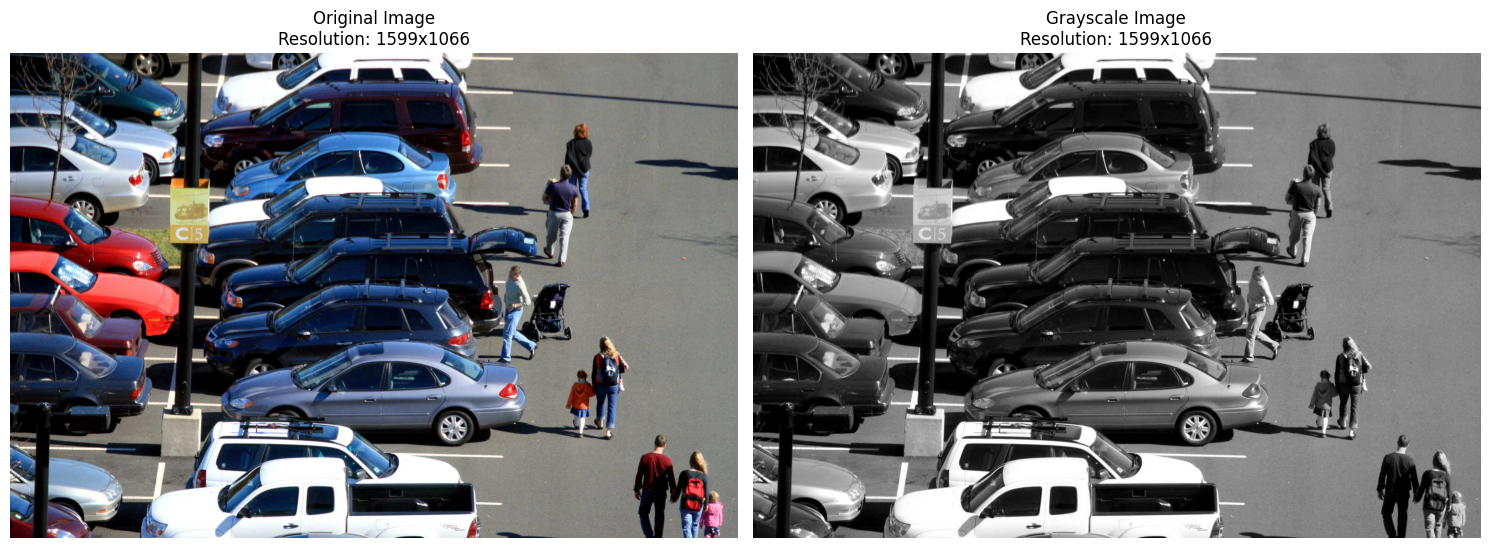

Original image shape: (1066, 1599, 3)
Grayscale image shape: (1066, 1599)


In [2]:
# Load the high-resolution image
image_path = 'parking-lot-1442053.jpg'
original_image = cv2.imread(image_path)
original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Convert to grayscale
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Display original and grayscale images
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].imshow(original_image_rgb)
axes[0].set_title(f'Original Image\nResolution: {original_image.shape[1]}x{original_image.shape[0]}')
axes[0].axis('off')

axes[1].imshow(gray_image, cmap='gray')
axes[1].set_title(f'Grayscale Image\nResolution: {gray_image.shape[1]}x{gray_image.shape[0]}')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print(f"Original image shape: {original_image.shape}")
print(f"Grayscale image shape: {gray_image.shape}")


## 2. Sampling with Different Interpolation Techniques

We'll downsample the image and then upsample it back using different interpolation methods:
- **Nearest Neighbour**: Simplest method, uses closest pixel value
- **Bilinear**: Uses weighted average of 4 nearest pixels
- **Bicubic**: Uses weighted average of 16 nearest pixels (smoother)
- **Lanczos**: Uses sinc function for high-quality resampling


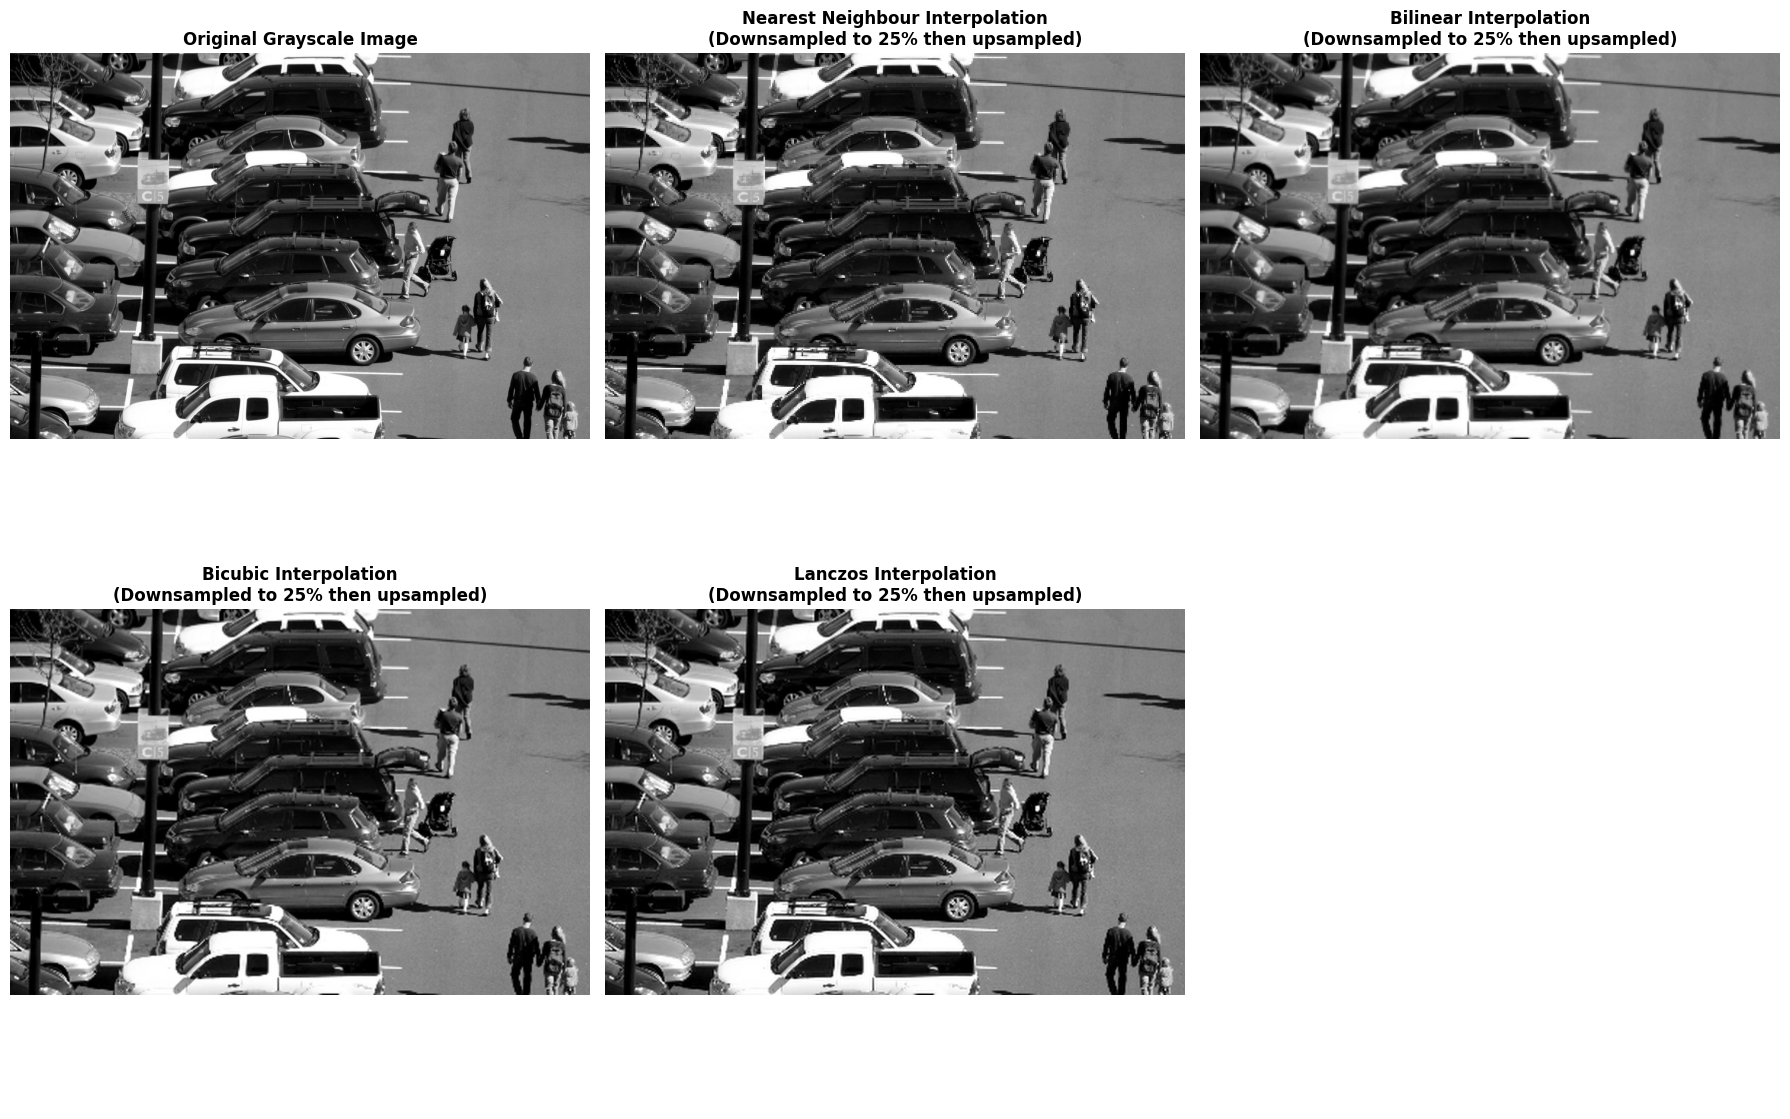

In [3]:
# Define sampling function
def apply_sampling(image, scale_factor=0.25):
    """
    Downsample and then upsample using different interpolation methods
    """
    original_size = (image.shape[1], image.shape[0])
    downsampled_size = (int(image.shape[1] * scale_factor), int(image.shape[0] * scale_factor))
    
    results = {}
    
    # 1. Nearest Neighbour Interpolation
    downsampled = cv2.resize(image, downsampled_size, interpolation=cv2.INTER_NEAREST)
    results['Nearest Neighbour'] = cv2.resize(downsampled, original_size, interpolation=cv2.INTER_NEAREST)
    
    # 2. Bilinear Interpolation
    downsampled = cv2.resize(image, downsampled_size, interpolation=cv2.INTER_LINEAR)
    results['Bilinear'] = cv2.resize(downsampled, original_size, interpolation=cv2.INTER_LINEAR)
    
    # 3. Bicubic Interpolation
    downsampled = cv2.resize(image, downsampled_size, interpolation=cv2.INTER_CUBIC)
    results['Bicubic'] = cv2.resize(downsampled, original_size, interpolation=cv2.INTER_CUBIC)
    
    # 4. Lanczos Interpolation
    downsampled = cv2.resize(image, downsampled_size, interpolation=cv2.INTER_LANCZOS4)
    results['Lanczos'] = cv2.resize(downsampled, original_size, interpolation=cv2.INTER_LANCZOS4)
    
    return results

# Apply sampling with different interpolation methods
sampling_results = apply_sampling(gray_image, scale_factor=0.25)

# Display results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original image
axes[0, 0].imshow(gray_image, cmap='gray')
axes[0, 0].set_title('Original Grayscale Image', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Interpolation results
interpolation_methods = ['Nearest Neighbour', 'Bilinear', 'Bicubic', 'Lanczos']
positions = [(0, 1), (0, 2), (1, 0), (1, 1)]

for method, pos in zip(interpolation_methods, positions):
    axes[pos].imshow(sampling_results[method], cmap='gray')
    axes[pos].set_title(f'{method} Interpolation\n(Downsampled to 25% then upsampled)', 
                        fontsize=12, fontweight='bold')
    axes[pos].axis('off')

# Remove empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


Zoomed comparison showing interpolation artifacts:


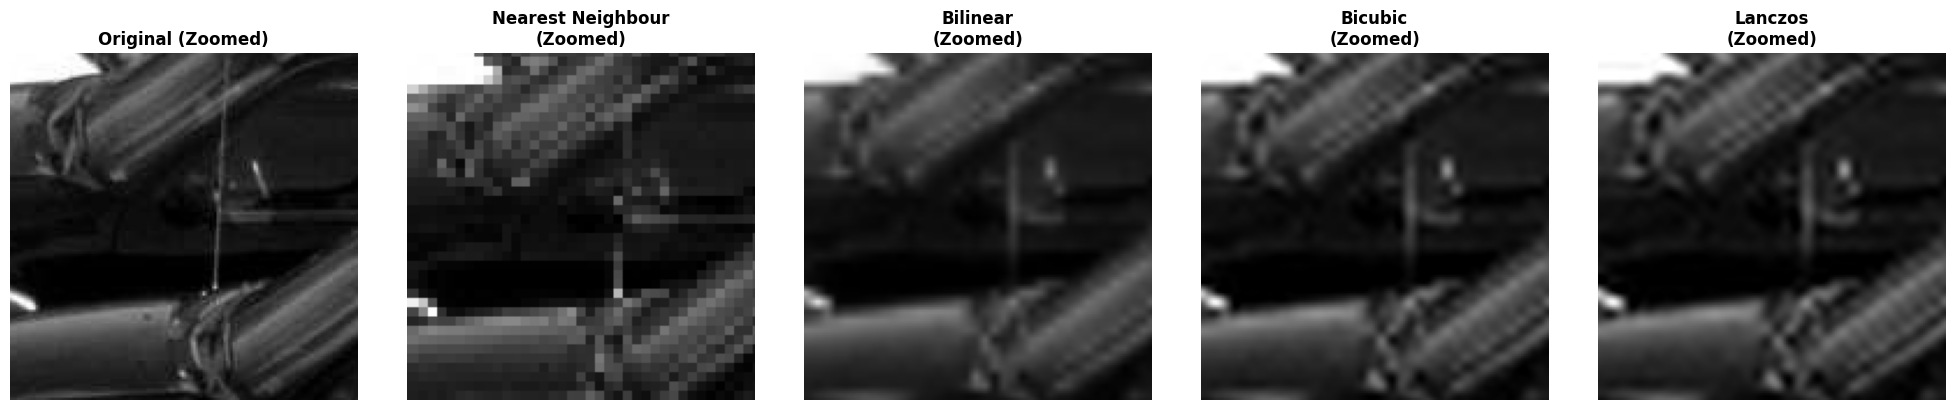

In [4]:
# Zoomed comparison of a region to see interpolation differences
def show_zoomed_comparison(original, results, x, y, size=100):
    """Show zoomed region to compare interpolation quality"""
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    
    # Original
    axes[0].imshow(original[y:y+size, x:x+size], cmap='gray')
    axes[0].set_title('Original (Zoomed)', fontweight='bold')
    axes[0].axis('off')
    
    # Each interpolation method
    for idx, (method, img) in enumerate(results.items(), 1):
        axes[idx].imshow(img[y:y+size, x:x+size], cmap='gray')
        axes[idx].set_title(f'{method}\n(Zoomed)', fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Show zoomed comparison (focusing on a car region)
print("Zoomed comparison showing interpolation artifacts:")
show_zoomed_comparison(gray_image, sampling_results, 
                       x=gray_image.shape[1]//3, 
                       y=gray_image.shape[0]//3, 
                       size=150)


## 3. Quantization at Different Bit Levels

Quantization reduces the number of distinct intensity levels:
- **8-bit**: 256 levels (original)
- **6-bit**: 64 levels
- **4-bit**: 16 levels
- **2-bit**: 4 levels


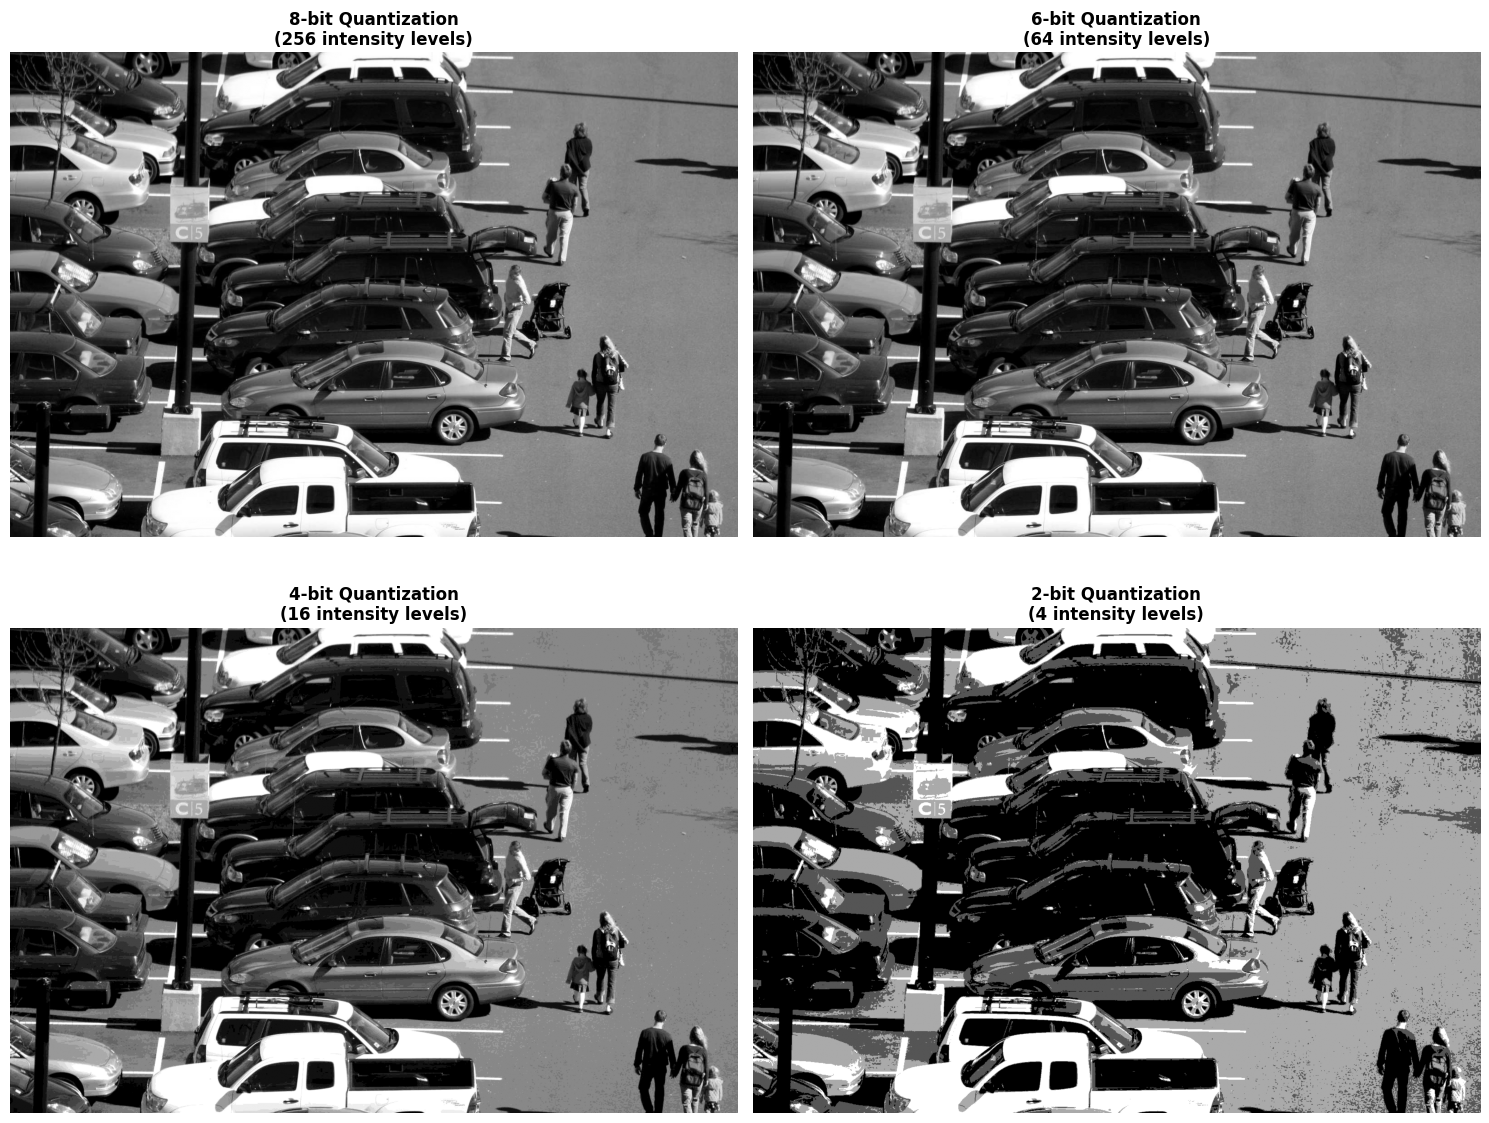

8-bit: 256 possible levels, 256 unique values in image
6-bit: 64 possible levels, 64 unique values in image
4-bit: 16 possible levels, 16 unique values in image
2-bit: 4 possible levels, 4 unique values in image


In [5]:
# Define quantization function
def quantize_image(image, bits):
    """
    Reduce the number of intensity levels in an image
    """
    # Calculate number of levels
    levels = 2 ** bits
    
    # Quantize the image
    # Scale to 0-levels range, floor, then scale back to 0-255
    quantized = np.floor(image / 256 * levels) * (256 / levels)
    quantized = np.clip(quantized, 0, 255).astype(np.uint8)
    
    return quantized

# Apply different quantization levels
bit_levels = [8, 6, 4, 2]
quantized_images = {}

for bits in bit_levels:
    quantized_images[f'{bits}-bit'] = quantize_image(gray_image, bits)

# Display quantized images
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, bits in enumerate(bit_levels):
    axes[idx].imshow(quantized_images[f'{bits}-bit'], cmap='gray')
    axes[idx].set_title(f'{bits}-bit Quantization\n({2**bits} intensity levels)', 
                        fontsize=12, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Print statistics
for bits in bit_levels:
    unique_values = len(np.unique(quantized_images[f'{bits}-bit']))
    print(f"{bits}-bit: {2**bits} possible levels, {unique_values} unique values in image")


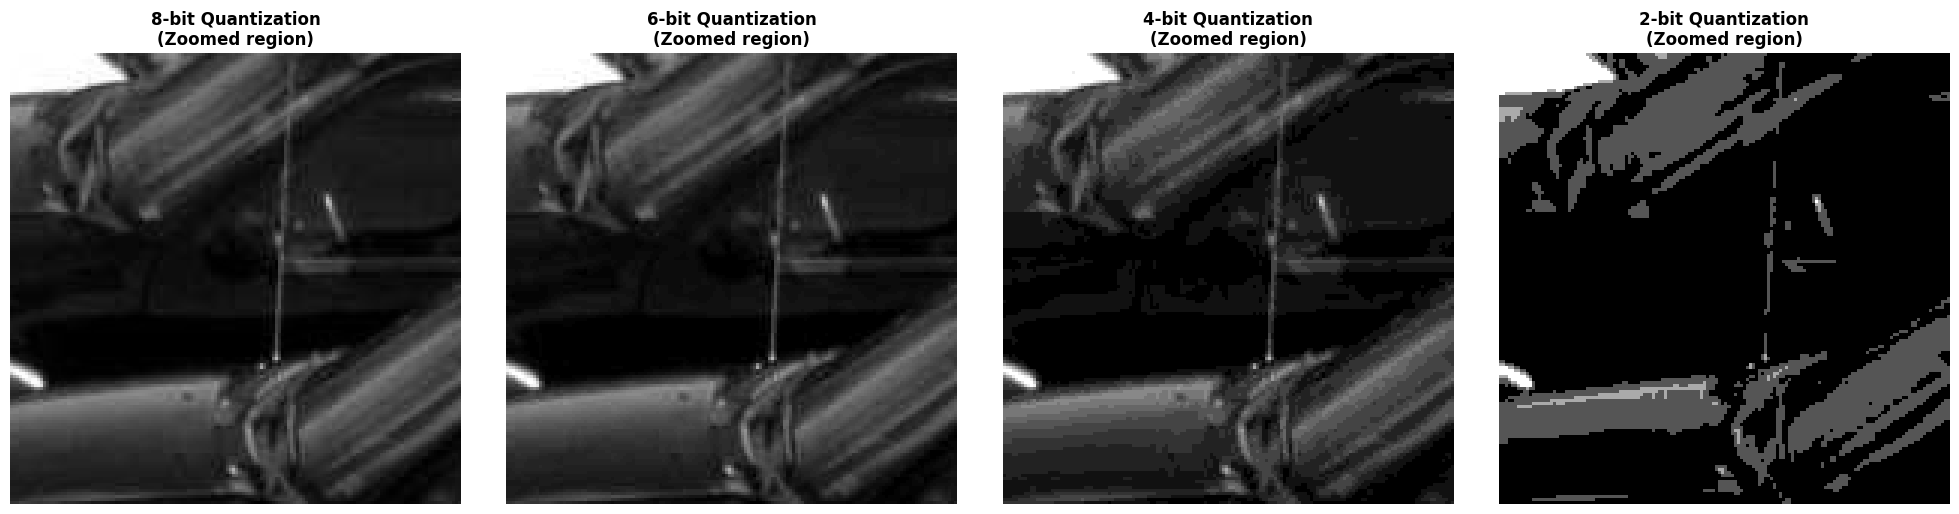

In [6]:
# Zoomed comparison for quantization
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

x, y, size = gray_image.shape[1]//3, gray_image.shape[0]//3, 150

for idx, bits in enumerate(bit_levels):
    axes[idx].imshow(quantized_images[f'{bits}-bit'][y:y+size, x:x+size], cmap='gray')
    axes[idx].set_title(f'{bits}-bit Quantization\n(Zoomed region)', fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


## 4. Combined Effects: Sampling + Quantization

Let's see what happens when we combine low sampling resolution with low quantization levels.


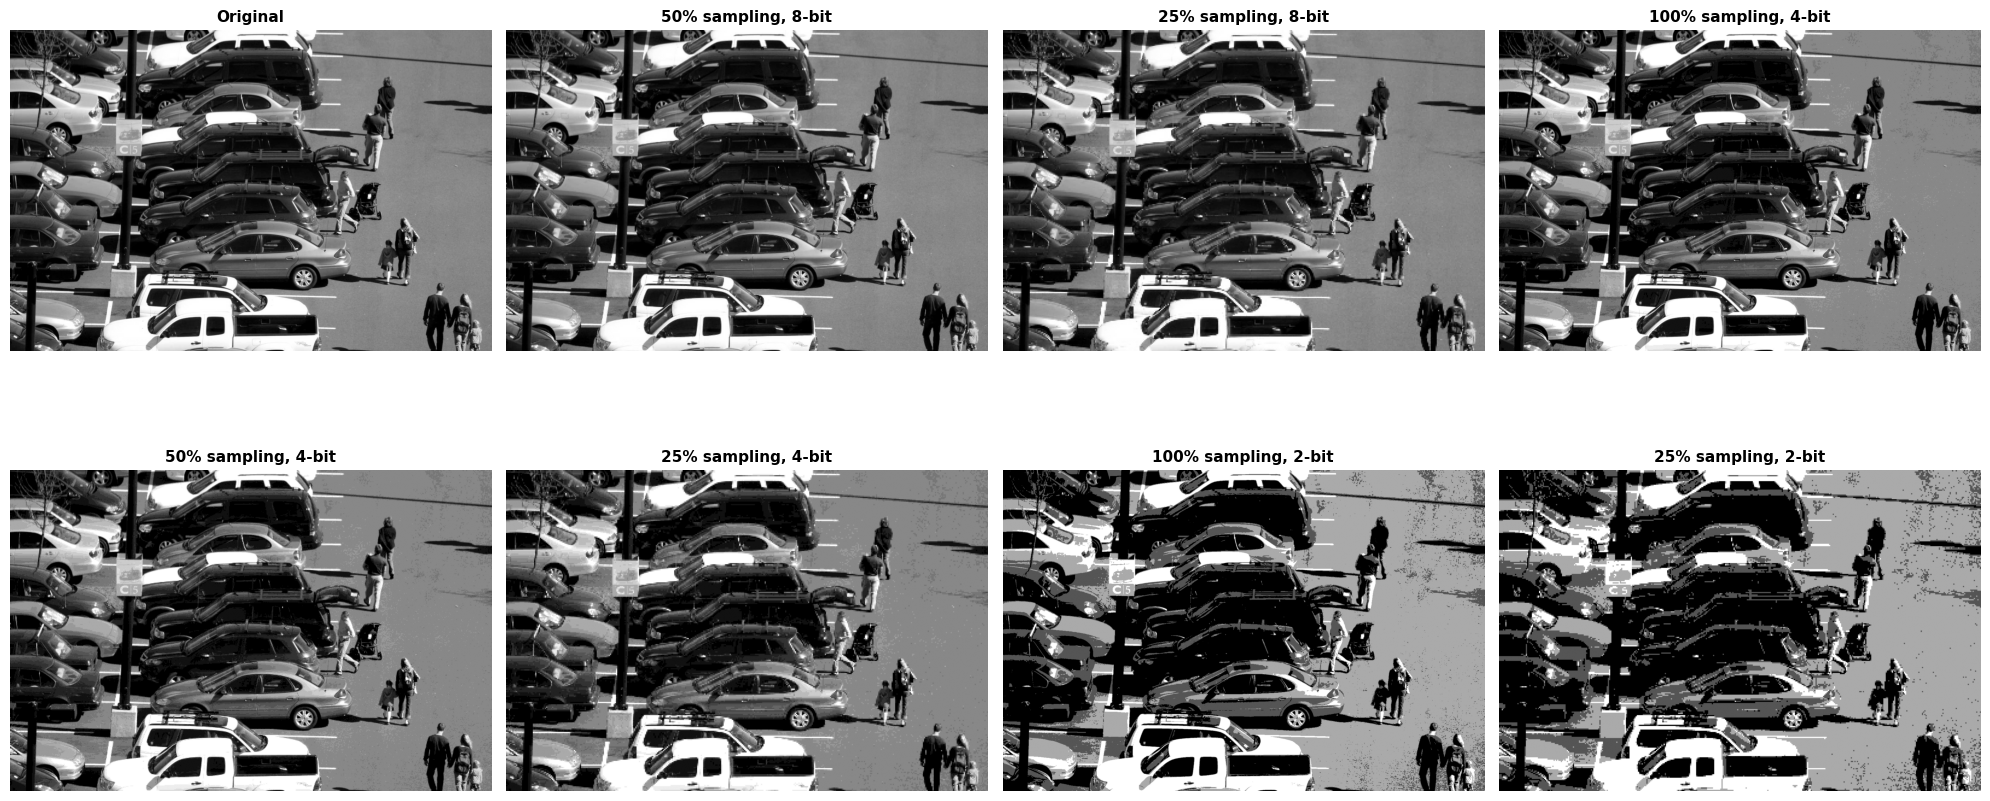

In [7]:
# Apply both sampling (with nearest neighbour) and quantization
def apply_combined_effects(image, scale_factor=0.25, bits=4):
    """Apply both downsampling and quantization"""
    # First downsample and upsample
    original_size = (image.shape[1], image.shape[0])
    downsampled_size = (int(image.shape[1] * scale_factor), int(image.shape[0] * scale_factor))
    
    downsampled = cv2.resize(image, downsampled_size, interpolation=cv2.INTER_NEAREST)
    upsampled = cv2.resize(downsampled, original_size, interpolation=cv2.INTER_NEAREST)
    
    # Then quantize
    quantized = quantize_image(upsampled, bits)
    
    return quantized

# Create images with different combinations
combinations = [
    (1.0, 8, "Original"),
    (0.5, 8, "50% sampling, 8-bit"),
    (0.25, 8, "25% sampling, 8-bit"),
    (1.0, 4, "100% sampling, 4-bit"),
    (0.5, 4, "50% sampling, 4-bit"),
    (0.25, 4, "25% sampling, 4-bit"),
    (1.0, 2, "100% sampling, 2-bit"),
    (0.25, 2, "25% sampling, 2-bit"),
]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, (scale, bits, title) in enumerate(combinations):
    if scale == 1.0 and bits == 8:
        img = gray_image
    elif scale == 1.0:
        img = quantize_image(gray_image, bits)
    else:
        img = apply_combined_effects(gray_image, scale, bits)
    
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(title, fontsize=11, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


## 5. Analysis and Observations

### Question 6: What artifacts do you observe at lower sampling and quantization levels?

**Artifacts from Low Sampling (Spatial Resolution):**
1. **Pixelation/Blockiness**: Images appear blocky, especially with nearest neighbour interpolation
2. **Loss of fine details**: Small features like thin lines, text, and edges become blurred or disappear
3. **Jagged edges (Aliasing)**: Diagonal lines and curves appear stepped or jagged
4. **Blurring**: With bilinear/bicubic interpolation, images become smooth but lose sharpness

**Artifacts from Low Quantization (Intensity Resolution):**
1. **False Contouring/Banding**: Smooth gradients become discrete bands or contours
2. **Posterization**: Images look like posters with flat color regions
3. **Loss of subtle details**: Low-contrast features disappear when intensity levels merge
4. **Reduced dynamic range**: Cannot represent subtle variations in brightness

**Combined Artifacts:**
When both sampling and quantization are reduced, artifacts compound - you get blocky, posterized images with severe loss of detail.


### Question 7: Which degrades image quality more: low sampling resolution or low quantization levels? Why?

**Answer:**

**Low sampling resolution typically degrades image quality more** than low quantization levels, especially for images with important spatial details. Here's why:

**Spatial Resolution (Sampling):**
- **Irreversible loss of spatial information**: Once spatial details are lost through downsampling, they cannot be recovered
- **Affects structural integrity**: Shapes, edges, and object boundaries are fundamentally altered
- **Critical for recognition**: Human perception relies heavily on spatial patterns for object recognition
- **More visually disturbing**: Blocky, pixelated images are immediately noticeable and jarring

**Intensity Resolution (Quantization):**
- **Preserves spatial structure**: Edges and shapes remain intact, only intensity variations are affected
- **More graceful degradation**: Even 4-bit images are often recognizable
- **Human eye is less sensitive**: Our visual system is more tolerant of intensity quantization than spatial distortion
- **Context helps**: Brain can "fill in" missing intensity levels using spatial context

**However, the answer depends on image content:**
- For images with **smooth gradients** (sky, skin): Low quantization is more problematic (causes banding)
- For images with **fine details** (text, patterns): Low sampling is more problematic (causes blur/pixelation)

**Conclusion:**
For the parking lot image with cars and people, low sampling resolution is worse because it destroys important spatial details needed for vehicle and person identification.


### Question 8: How would these concepts affect image compression or transmission?

**Impact on Image Compression:**

**1. Sampling (Spatial Resolution):**
- **File size reduction**: Lower resolution = fewer pixels = smaller file size
- **Compression ratio**: Downsampling by 50% reduces file size by ~75% (half width × half height)
- **Used in**: Thumbnails, progressive image loading, video streaming (different quality levels)
- **Trade-off**: Cannot recover lost spatial information later

**2. Quantization (Bit Depth):**
- **Direct compression**: 8-bit → 4-bit reduces data by 50% per pixel
- **Enables better compression**: Fewer distinct values compress better with algorithms like RLE, Huffman coding
- **Used in**: JPEG (quantizes DCT coefficients), PNG (reduces palette)
- **Trade-off**: Visual quality degrades with contouring/banding

**3. Interpolation Methods:**
- **Nearest Neighbour**: Fastest, smallest computational cost, good for transmission
- **Bilinear/Bicubic**: Better quality but more computation
- **Lanczos**: Best quality but highest computational cost
- **Streaming consideration**: Simpler interpolation = faster decoding on receiver's device

**Impact on Image Transmission:**

**1. Bandwidth Considerations:**
- Lower sampling + quantization = Less data to transmit
- Critical for: Mobile networks, satellite imagery, video conferencing
- Example: Reduce from 1920×1080×8-bit to 640×480×4-bit = ~12× less data

**2. Progressive Transmission:**
- Send low-resolution/low-bit version first (quick preview)
- Gradually send higher resolution data
- Used in: Web images, JPEG progressive mode

**3. Adaptive Streaming:**
- Adjust resolution/bit depth based on network conditions
- High bandwidth → High quality
- Low bandwidth → Reduced sampling/quantization
- Used in: YouTube, Netflix (adaptive bitrate streaming)

**4. Real-world Applications:**

| Application | Strategy | Reason |
|------------|----------|---------|
| Video Calls | Low sampling, 8-bit color | Need real-time, motion matters more |
| Medical Imaging | High sampling, high bit depth | Cannot lose diagnostic information |
| Thumbnails | Very low sampling, 8-bit | Quick preview only |
| Satellite Imagery | High sampling, reduced quantization | Spatial detail critical |
| Mobile Photos | Moderate sampling, 8-bit | Balance size vs quality |

**Conclusion:**
Understanding sampling and quantization is fundamental to modern image/video compression standards (JPEG, MPEG, H.264, etc.) and enables efficient multimedia transmission across bandwidth-constrained networks.
